In [3]:

import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# settings
e3_csv = "./data/e3.csv"
e3_class_column = "Class"
e3_uniprot_column = "Uniprot"
data_json_output = "./data/e3.json"
summary_csv_output = "./data/e3_summary.csv"
tm_domains_fasta_output = "./data/tm_domains.fasta"
tm_domains_shuffle_fasta_output = "./data/tm_domains_shuffle.fasta"

In [4]:
# analyze data
with open(data_json_output, 'r') as f:
    data = json.load(f)
if not data or not isinstance(data, list):
    raise ValueError(f'Invalid data "{data_json_output}"')
summaries = []
e3_df = pd.read_csv(e3_csv)
for e in data:
    summary = {k: e.get(k) for k in ['uniprot_id', 'gene_name']}
    subcellular_locations_lower = [s.lower() for s in e.get('subcellular_locations', list())]
    summary['membrane'] = ', '.join(subcellular_locations_lower)
    summary['type'] = e3_df.loc[e3_df[e3_uniprot_column] == e.get('uniprot_id'), e3_class_column].iat[0]
    tm_num = 0
    for f in e.get('features', list()):
        if f['type'] == 'transmembrane region':
            tm_num += 1
    if tm_num:
        summary['transmembrane_num'] = tm_num
    else:
        summary['transmembrane_num'] = np.nan
    summaries.append(summary)
summaries_df = pd.DataFrame(summaries)
summaries_df.to_csv(summary_csv_output)

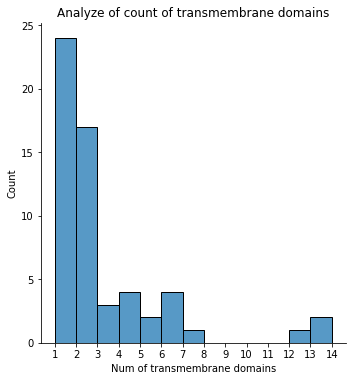

In [5]:
# analyze count of transmembrane domains
transmembrane_num_list = summaries_df['transmembrane_num'].to_numpy()
transmembrane_num_list = transmembrane_num_list[~np.isnan(transmembrane_num_list)]
g = sns.displot(transmembrane_num_list, bins=int(max(transmembrane_num_list)), binwidth=1)
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
g.set(title='Analyze of count of transmembrane domains', xlabel='Num of transmembrane domains', ylabel='Count')
plt.show()

In [9]:
# generate fasta file for each transmembrane region, together with shuffled version as control
with open(tm_domains_fasta_output, 'w+') as fasta:
   with open(tm_domains_shuffle_fasta_output, 'w+') as fasta_shuffle:
      for e in data:
         gene = e['gene_name']
         sequence = e['sequence']
         index = 0
         for f in e['features']:
            if f['type'] == 'transmembrane region':
               index += 1
               start = int(f['location'][0])
               end = int(f['location'][1])
               desc = f['description'].split(';')[0]
               seq = sequence[start-1:end]
               fasta.write(f'>{gene}|TM {index}|{start}-{end}|{desc}\n')
               fasta_shuffle.write(f'>{gene}|TM {index}|{start}-{end}|{desc}|Shuffle\n')
               fasta.write(seq + '\n')
               fasta_shuffle.write(''.join(random.sample(seq,len(seq))) + '\n')